# Action Regression
- This is the notebook dedicated to making the model for all action movies

In [38]:
# all of the many imports needed to make the dataset, and then make the model for the dataset
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from copy import deepcopy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import dill
import time
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import string
from concurrent.futures import ThreadPoolExecutor, wait
from random import uniform
import random
import pickle
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.preprocessing import MultiLabelBinarizer
from copy import deepcopy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from copy import deepcopy
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D
from keras import regularizers
from random import sample
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Loading the Raw Data
this includes the master dataframe of all the movies and the master dictionaries for all of the actors and directors

In [2]:
with open('all_genres_df.pkl', 'rb') as f: 
    films = pickle.load(f)
    
with open('wd_popularity.pkl', 'rb') as f:
    wd_pop = pickle.load(f)
wd_pop_names = list(wd_pop.keys())
    
with open('actor_popularity.pkl', 'rb') as f:
    actor_pop = pickle.load(f)
cast_pop_names = list(actor_pop.keys())

all_dict = wd_pop | actor_pop
for key, val in list(all_dict.items()):
    all_dict[key]['average'] = round(np.mean(list(val.values())))
    for key1, val1 in list(val.items()):
        if val1 >= 1000000:
            all_dict[key][key1] = 1000000

## Setting up the Transformer Objects
It was necessary for the objects to be instantiated seperately so that I didn't accidentaly clear them

In [3]:
mlb_genres = MultiLabelBinarizer(sparse_output=True)
mlb_languages = MultiLabelBinarizer(sparse_output=True)
mlb_country = MultiLabelBinarizer(sparse_output=True)
ohe = OneHotEncoder(handle_unknown = 'ignore')
vect_act = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, lowercase = True)
vect_dir = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, lowercase = True)
vect_write = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, lowercase = True)
vect_key = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, lowercase = True)
vect_prod = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, lowercase = True)

ACT_DATA = []
DIR_DATA = []
WRITE_DATA = []
KEY_DATA = []
PROD_DATA = []

## Making the Dataset
This is where I make a dataset specifically for this movie genre, as well as formatting for the model

In [4]:
# this function will return a dataset of the specified genre, where the people columns are of the minimum popularity
def make_dataset(genre, min_pop):
    tdf = deepcopy(films)
    
    # here I expand the genres column first so that I can reduce the dataframe to just the columns of the specified genre
    tdf = tdf.join(pd.DataFrame.sparse.from_spmatrix(mlb_genres.fit_transform(tdf.pop('genres')), index = tdf.index, columns = mlb_genres.classes_))
    tdf = tdf[tdf[genre] == 1]
    
    # here I get rid of rows and columns that are unnecessary 
    tdf = tdf[tdf['num_review'] > 200]
    tdf = tdf.reset_index().drop('index', axis =1)
    tdf = tdf.drop(['Biography', 'Documentary', 'Film-Noir', 'Music', 'Musical', 'News', 'Reality-TV', 'Sport'], axis = 1)
    
    # these are the popularity columns that will be filled in later
    tdf['dir_pop'] = 0
    tdf['write_pop'] = 0
    tdf['cast_pop'] = 0      
    
    # expanding the languages and country columns
    tdf = tdf.join(pd.DataFrame.sparse.from_spmatrix(mlb_languages.fit_transform(tdf.pop('languages')), index = tdf.index, columns = mlb_languages.classes_), lsuffix = '_left')
    tdf = tdf.join(pd.DataFrame.sparse.from_spmatrix(mlb_country.fit_transform(tdf.pop('country')), index = tdf.index, columns = mlb_country.classes_), lsuffix = '_left')

    # expanding and reducing the prod_comp, key_words, actors, director, and writer columns
    tdf = dim_reduction(tdf, 'prod_comp', 1, min_pop)
    tdf = dim_reduction(tdf, 'key_words', 10, min_pop)
    # this variable is a placeholder so I know which columns represent individual people
    temp = tdf.shape[1]
    tdf = dim_reduction(tdf, 'actors', 3, min_pop)
    tdf = dim_reduction(tdf, 'director', 1, min_pop)
    tdf = dim_reduction(tdf, 'writer', 1, min_pop)  

    # here I add in the movie rating columns for "R", "PG-13", etc..
    rating = pd.DataFrame(ohe.fit_transform(tdf[['m_rating']]).toarray(), columns = ohe.get_feature_names(['m_rating']))
    rating.columns = [col[9:] for col in list(rating.columns)]
    rating.index = tdf.index
    tdf = pd.concat([tdf, rating], 1).drop('m_rating', axis =1)
    
    # list of all of the poeple involved in the movie
    people_list = list(tdf.columns)[temp-4:]
    
    return(tdf, people_list)

In [5]:
# this function is for reducing the number of columns from the dataframe so that the outliers can be removed
# in this case, outliers would be actors/directors/writers that did not participate in many movies

def dim_reduction(baseline_df, column, min_freq, min_pop):
    # each column needs a seperate mlb object so that we can use the seperate obejects later to correctly predict new movies
    # that are not in the dataset
    if column == 'actors':
        vectorizer = vect_act
    elif column == 'director':
        vectorizer = vect_dir
    elif column == 'writer':
        vectorizer = vect_write
    elif column == 'key_words':
        vectorizer = vect_key
    elif column == 'prod_comp':
        vectorizer = vect_prod
        
    # this is where I set up the dataframe that will show which columns are important and which are not
    count_data = vectorizer.fit_transform(baseline_df[column])    
    movie_data = pd.DataFrame(data = count_data.toarray(), index = baseline_df.index, columns = vectorizer.get_feature_names())
    # this will add the role of the person to their string name so that you will know if that person acted as a director vs writer vs actor
    movie_data.columns = [name + ' ' + column for name in list(movie_data.columns)]
        
    # big list will act as the list of how freqent one name shows up in the column
    big_list = movie_data.sum()
    # good data will be the columns that will be kept in the ultimate genre dataframe
    good_data = []

    # here I get rid of all names that showed up less than or equal to the min_freq input or are more popular than the min_pop
    for data in big_list.index:
        data_freq = big_list[data]
        try:
            # this retreives the average popularity for a person across their whole career
            data_pop = all_dict[data.replace((' ' + column), '')]['average']
        except:
            # if I don't have any info on the person then the actor popularity number will not help
            data_pop = 1000000
            
        # the popularity metric means that the lower the score, the more popular you are, I will flip this later
        if (data_freq > min_freq) | (data_pop < min_pop):
            good_data.append(data)
    
    # I need to save which columns are being used for later when i make predictions on individual movies that are note in the dataframe
    if column == 'actors':
        for col in good_data:
            ACT_DATA.append(col)
    elif column == 'director':
        for col in good_data:
            DIR_DATA.append(col)
    elif column == 'writer':
        for col in good_data:
            WRITE_DATA.append(col)
    elif column == 'key_words':
        for col in good_data:
            KEY_DATA.append(col)
    elif column == 'prod_comp':
        for col in good_data:
            PROD_DATA.append(col)
            
    # returning the whole dataset minus the columns that were irrelavent
    return baseline_df.join(movie_data[good_data], lsuffix = '_left').drop(column, axis = 1)

In [6]:
raw_df, p_list = make_dataset('Action', 10000)

In [17]:
raw_df.shape

(11928, 28475)

In [ ]:
len(p_list)

In [ ]:
# saving the unfinished dataframe for the sake of caution, in case of a crash
with open('./Action/action_raw_df.pkl', 'wb') as f:
    pickle.dump(raw_df, f)

with open('./Action/action_people.pkl', 'rb') as f:
    pickle.dump(p_list, f)

In [20]:
# loading option so you don't have to run everything above
with open('./Action/action_raw_df.pkl', 'rb') as f:
    raw_df = pickle.load(f)
print(raw_df.shape)

with open('./Action/action_people.pkl', 'rb') as f:
    p_list = pickle.load(f)
print(len(p_list))

(11928, 28475)
12892


## Adding the Popularity Metric
Here we use the popularity scores to get the total popularity of the actors, writers, and directors involved in each film

In [7]:
# this function will get a subset of the dataframe that contains movies of the specified person, and then updates popularity column
def popularity(name, df):
    # getting the dictionary for the individual person
    pop_scores = all_dict[name]
    
    # preparing several lists to find the right scores in dictionary of scores
    act_df = df[df[name] == 1]
    years = act_df.release_date.tolist()
    cast_pop = act_df.cast_pop.tolist()
    dir_pop = act_df.dir_pop.tolist()
    write_pop = act_df.write_pop.tolist()
    
    update_pop = []
    for row in act_df.release_date:
        try:
            update_pop.append(1000000 - pop_scores[row.year])
        except:
            update_pop.append(1000000 - pop_scores['average'])

    # Check the name to choose which column we update
    if ' actors' in name:
        act_df.cast_pop = list(np.array(cast_pop) + np.array(update_pop))
    elif ' director' in name: 
        act_df.dir_pop = list(np.array(dir_pop) + np.array(update_pop))
    elif ' writer' in name: 
        act_df.write_pop = list(np.array(write_pop) + np.array(update_pop))
      
    return pd.concat([df[df[name] != 1], act_df])

In [8]:
def finish_dataset(tdf, p_list):
    count = 0
    for person in p_list:
        count += 1
        tdf = popularity(person, tdf)
        print(count, end = '\r')
    return tdf

In [9]:
final = finish_dataset(raw_df, p_list)

In [23]:
# check to see that everything worked as expected
final.sort_values('num_review', ascending = False)[['title', 'cast_pop', 'dir_pop', 'write_pop']]

,title,cast_pop,dir_pop,write_pop
5613,The Dark Knight,7999782.0,999953.0,2778729.0
2683,Inception,7998185.0,999972.0,999972.0
5611,The Lord of the Rings: The Fellowship of the Ring,7996171.0,999786.0,2986173.0
2696,The Matrix,8925920.0,1999690.0,1999690.0
5628,The Lord of the Rings: The Return of the King,6995188.0,999930.0,2991567.0
...,...,...,...,...
9951,King of the Jungle,2972433.0,946333.0,0.0
11784,I'm Flash!,1920111.0,950636.0,0.0
5477,Hercules Against the Barbarians,937426.0,913305.0,1827165.0
2638,Ildan dwieo,1887791.0,0.0,0.0


In [22]:
with open('./Action/Action_df.pkl', 'rb') as f:
    final = pickle.load(f)

In [24]:
# check to see the dataframe is as expected
final

,id,title,release_date,runtime,imdb_rating,num_review,Action,Adventure,Animation,Comedy,...,R,TV-14,TV-G,TV-MA,TV-PG,TV-Y7,TV-Y7-FV,UNK,Unrated,X
89,1843303,The VelociPastor,2019-08-13 00:00:00,75.0,5.0,6600.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,14270848,Robbing Mussolini,2022-10-26 00:00:00,90.0,5.4,1700.0,1,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
341,8305692,Santa Jaws,2018-08-14 00:00:00,88.0,4.0,1200.0,1,1,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
409,13882736,Cop Secret,2021-10-20 00:00:00,98.0,6.3,889.0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
419,5689068,Killing Gunther,2017-09-22 00:00:00,92.0,4.8,14000.0,1,0,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11012,0926763,Le nouveau protocole,2008-03-19 00:00:00,92.0,6.1,970.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10198,1959346,Blind Man,2012-03-07 00:00:00,94.0,5.7,1200.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3070,0364970,Babylon A.D.,2008-08-29 00:00:00,90.0,5.5,96000.0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7427,0347330,Cash Truck,2004-04-14 00:00:00,95.0,6.5,4100.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Starting the Model
here is the start of the modeling process using Neural Networking

In [29]:
df = final.drop(['id', 'title'], axis = 1)
df.release_date = pd.to_datetime(df.release_date)
df.release_date = df.release_date.apply(lambda x: x.toordinal())

In [30]:
# basic train test split for the modeling
X = df.drop('imdb_rating', axis = 1)
y = df['imdb_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1764)

In [31]:
# scaling
ss = StandardScaler()
x_train_ss_scaled = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns)
x_test_ss_scaled = pd.DataFrame(ss.transform(X_test),columns = X_test.columns)
x_val_ss_scaled = pd.DataFrame(ss.transform(X_val),columns = X_val.columns)

In [32]:
# this PCA is very important for reducing the amount of time it takes for the model to run
pca = PCA(n_components = 8000, random_state = 42)
pca_x_train = pca.fit_transform(x_train_ss_scaled)
pca_x_val = pca.transform(x_val_ss_scaled)
pca_x_test = pca.transform(x_test_ss_scaled)

In [33]:
# here we check to see that at least 95% of the variance is captured by the pca
pca.explained_variance_ratio_.sum()

0.9992814464289722

In [34]:
# putting in a decaying learning rate lets the model run faster and more accurate
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.03)

### The Neural Network model

In [44]:
# add in early stopping to make sure the model does not run longer than it has too
early = [EarlyStopping(monitor='loss', min_delta = 0.001, patience = 20, mode = 'min'),
        ModelCheckpoint(filepath = './Action/action_model.h5', monitor = 'loss', save_best_only = True),
        LearningRateScheduler(scheduler)]
opt = Adam(learning_rate = 0.0015)

pca_ss_model = Sequential()
pca_ss_model.add(Conv1D(filters = 20, kernel_size = (3), activation = 'relu', input_shape = (8000,1), 
                      padding = 'causal', kernel_initializer = 'normal'))
pca_ss_model.add(MaxPooling1D(pool_size = (2)))
pca_ss_model.add(Dropout(0.3))

pca_ss_model.add(Conv1D(filters = 10, kernel_size = (3), activation = 'tanh', padding = 'causal'))
pca_ss_model.add(MaxPooling1D(pool_size = (2)))
pca_ss_model.add(Dropout(0.3))

pca_ss_model.add(Flatten())

#base_model.add(Dropout(0.4))
pca_ss_model.add(Dense(128, activation = 'relu', kernel_initializer = 'normal', kernel_regularizer = regularizers.l2(0.005)))
pca_ss_model.add(Dropout(0.3))
pca_ss_model.add(Dense(100, activation = 'relu', kernel_initializer = 'normal', kernel_regularizer = regularizers.l2(0.005)))
pca_ss_model.add(Dropout(0.3))
pca_ss_model.add(Dense(64, activation = 'relu', kernel_initializer = 'normal', kernel_regularizer = regularizers.l2(0.005)))
pca_ss_model.add(Dropout(0.3))
pca_ss_model.add(Dense(32, activation = 'relu', kernel_initializer = 'normal', kernel_regularizer = regularizers.l2(0.005)))
pca_ss_model.add(Dropout(0.3))
pca_ss_model.add(Dense(16, activation = 'relu', kernel_initializer = 'normal', kernel_regularizer = regularizers.l2(0.005)))
pca_ss_model.add(Dropout(0.3))
pca_ss_model.add(Dense(8, activation = 'relu', kernel_initializer = 'normal', kernel_regularizer = regularizers.l2(0.005)))
pca_ss_model.add(Dropout(0.3))
pca_ss_model.add(Dense(1, kernel_initializer = 'normal'))

pca_ss_model.compile(loss = 'mse', optimizer = opt, metrics = ['mae'])

pca_ss_result = pca_ss_model.fit(pca_x_train, 
                                y_train.values, 
                                validation_data = [pca_x_val, y_val.values],
                                epochs = 120, 
                                callbacks = early, 
                                batch_size = 80)

y_test_pred = pca_ss_model.predict(pca_x_test)

this_mse = mean_squared_error(y_test, y_test_pred)
this_mae = mean_absolute_error(y_test, y_test_pred)
print(this_mse, this_mae)

Epoch 1/120
105/105 [==============================] - 11s 96ms/step - loss: 20.8423 - mae: 3.0144 - val_loss: 3.9172 - val_mae: 1.3232 - lr: 0.0015
Epoch 2/120
105/105 [==============================] - 9s 86ms/step - loss: 7.0455 - mae: 2.0357 - val_loss: 4.1519 - val_mae: 1.5898 - lr: 0.0015
Epoch 3/120
105/105 [==============================] - 9s 86ms/step - loss: 6.5295 - mae: 1.9806 - val_loss: 5.0479 - val_mae: 1.8441 - lr: 0.0015
Epoch 4/120
105/105 [==============================] - 9s 88ms/step - loss: 6.2096 - mae: 1.9496 - val_loss: 2.1999 - val_mae: 1.0507 - lr: 0.0015
Epoch 5/120
105/105 [==============================] - 9s 88ms/step - loss: 6.0847 - mae: 1.9245 - val_loss: 2.1739 - val_mae: 1.0156 - lr: 0.0015
Epoch 6/120
105/105 [==============================] - 10s 99ms/step - loss: 5.8571 - mae: 1.8892 - val_loss: 4.2780 - val_mae: 1.6758 - lr: 0.0014
Epoch 7/120
105/105 [==============================] - 12s 112ms/step - loss: 5.8865 - mae: 1.8867 - val_loss: 3.21

Epoch 55/120
105/105 [==============================] - 12s 110ms/step - loss: 2.0593 - mae: 0.9569 - val_loss: 1.7929 - val_mae: 0.8572 - lr: 3.2480e-04
Epoch 56/120
105/105 [==============================] - 12s 111ms/step - loss: 2.0162 - mae: 0.9447 - val_loss: 1.7778 - val_mae: 0.8582 - lr: 3.1520e-04
Epoch 57/120
105/105 [==============================] - 12s 115ms/step - loss: 1.9902 - mae: 0.9418 - val_loss: 1.7512 - val_mae: 0.8427 - lr: 3.0589e-04
Epoch 58/120
105/105 [==============================] - 12s 113ms/step - loss: 1.9469 - mae: 0.9275 - val_loss: 1.7547 - val_mae: 0.8601 - lr: 2.9685e-04
Epoch 59/120
105/105 [==============================] - 11s 110ms/step - loss: 1.9274 - mae: 0.9254 - val_loss: 1.7358 - val_mae: 0.8575 - lr: 2.8807e-04
Epoch 60/120
105/105 [==============================] - 12s 117ms/step - loss: 1.9159 - mae: 0.9245 - val_loss: 1.6912 - val_mae: 0.8378 - lr: 2.7956e-04
Epoch 61/120
105/105 [==============================] - 13s 119ms/step - los

105/105 [==============================] - 12s 110ms/step - loss: 1.3379 - mae: 0.7907 - val_loss: 1.4842 - val_mae: 0.8442 - lr: 6.6236e-05
Epoch 109/120
105/105 [==============================] - 12s 110ms/step - loss: 1.3520 - mae: 0.7972 - val_loss: 1.4681 - val_mae: 0.8352 - lr: 6.4278e-05
Epoch 110/120
105/105 [==============================] - 11s 107ms/step - loss: 1.3488 - mae: 0.7946 - val_loss: 1.4641 - val_mae: 0.8354 - lr: 6.2378e-05
Epoch 111/120
105/105 [==============================] - 11s 109ms/step - loss: 1.3209 - mae: 0.7860 - val_loss: 1.4588 - val_mae: 0.8326 - lr: 6.0535e-05
Epoch 112/120
105/105 [==============================] - 11s 108ms/step - loss: 1.3256 - mae: 0.7916 - val_loss: 1.4414 - val_mae: 0.8256 - lr: 5.8746e-05
Epoch 113/120
105/105 [==============================] - 11s 109ms/step - loss: 1.2792 - mae: 0.7714 - val_loss: 1.4449 - val_mae: 0.8282 - lr: 5.7010e-05
Epoch 114/120
105/105 [==============================] - 11s 109ms/step - loss: 1.33

In [46]:
print(this_mse, this_mae)

1.155212798708469 0.8410955510059549


In [36]:
# this function will allow us to visulaize the results of the Neural Network
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_mae'])
    plt.plot(history['mae'])
    plt.legend(['val_mae', 'mae'])
    plt.title('MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.show()

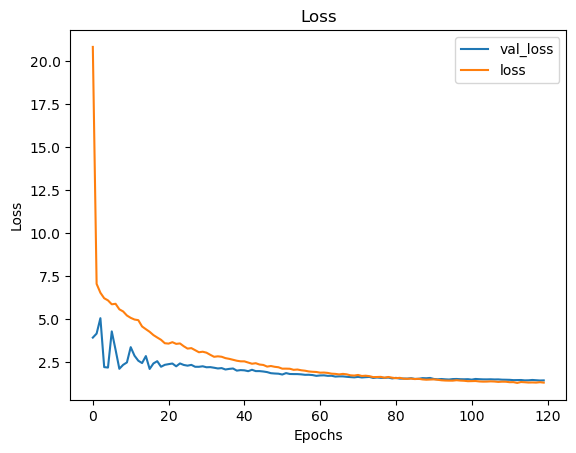

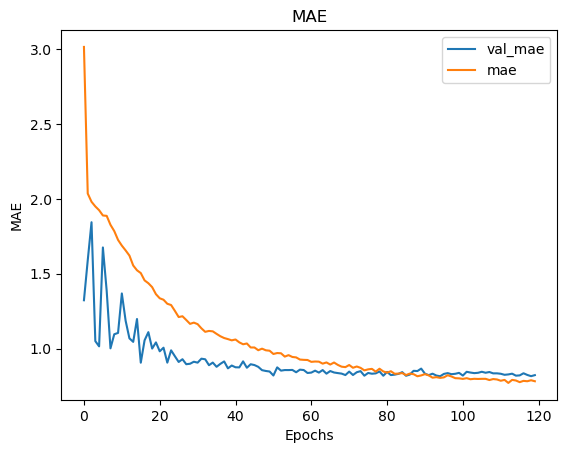

In [45]:
visualize_training_results(pca_ss_result)

In [47]:
# checking the results for the best model that the Neural Network produced
best_pca_ss_model = load_model('./Action/action_model.h5')
best_y_test_pred = best_pca_ss_model.predict(pca_x_test)

print(mean_squared_error(best_y_test_pred, y_test))
print(mean_squared_error(best_y_test_pred, y_test, squared = False))
print(mean_absolute_error(best_y_test_pred, y_test))

56/56 [==============================] - 1s 13ms/step
1.154778512504242
1.0746062127608615
0.8421649237584802


## Saving the Objects

In [43]:
# here we need to save all of the objects used to transform the dataset so that we can do it on any future movies
with open('./Action/mlb_genres.pkl', 'wb') as f:
    pickle.dump(mlb_genres, f)
with open('./Action/mlb_languages.pkl', 'wb') as f:
    pickle.dump(mlb_languages, f)
with open('./Action/mlb_country.pkl', 'wb') as f:
    pickle.dump(mlb_country, f)
with open('./Action/ohe.pkl', 'wb') as f:
    pickle.dump(ohe, f)
with open('./Action/vect_act.pkl', 'wb') as f:
    dill.dump(vect_act, f)
with open('./Action/vect_dir.pkl', 'wb') as f:
    dill.dump(vect_dir, f)
with open('./Action/vect_write.pkl', 'wb') as f:
    dill.dump(vect_write, f)
with open('./Action/vect_key.pkl', 'wb') as f:
    dill.dump(vect_key, f)
with open('./Action/vect_prod.pkl', 'wb') as f:
    dill.dump(vect_prod, f)
with open('./Action/ss.pkl', 'wb') as f:
    pickle.dump(ss, f)
with open('./Action/pca.pkl', 'wb') as f:
    pickle.dump(pca, f)
    
with open('./Action/action_columns.pkl', 'wb') as f:
    pickle.dump(ACT_DATA, f)
with open('./Action/director_columns.pkl', 'wb') as f:
    pickle.dump(DIR_DATA, f)
with open('./Action/writer_columns.pkl', 'wb') as f:
    pickle.dump(WRITE_DATA, f)
with open('./Action/key_columns.pkl', 'wb') as f:
    pickle.dump(KEY_DATA, f)
with open('./Action/prod_columns.pkl', 'wb') as f:
    pickle.dump(PROD_DATA, f)